In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from Utils.visualize import display_images
from Utils.utils import log
from Config.CustomConfig import CaltechBirdsConfig
from data.CustomDataset import CaltechBirdsDataset
from Utils import visualize
from Utils.utils import extract_bboxes, resize_image, resize_mask, generate_pyramid_anchors
from data.DataGenerator import load_image_gt, data_generator
from Utils.network_utils import compute_backbone_shapes
from Utils.utils import parse_image_meta, unmold_image, apply_box_deltas

Using TensorFlow backend.


In [2]:
ROOT_DIR = 'D:\\coursera\\maskrcnn'
MODEL_DIR = os.path.join(ROOT_DIR, "checkpoint")

ROOT_DIR, MODEL_DIR

('D:\\coursera\\maskrcnn', 'D:\\coursera\\maskrcnn\\checkpoint')

In [3]:
dataset = CaltechBirdsDataset()
dataset.load_birds('D:/DataSet/birds/', "train")
dataset.prepare()

5429it [00:29, 184.39it/s]


In [4]:
config = CaltechBirdsConfig()

In [5]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 5429
Class Count: 201
  0. BG                                                
  1. 001.Black_footed_Albatross                        
  2. 002.Laysan_Albatross                              
  3. 003.Sooty_Albatross                               
  4. 004.Groove_billed_Ani                             
  5. 005.Crested_Auklet                                
  6. 006.Least_Auklet                                  
  7. 007.Parakeet_Auklet                               
  8. 008.Rhinoceros_Auklet                             
  9. 009.Brewer_Blackbird                              
 10. 010.Red_winged_Blackbird                          
 11. 011.Rusty_Blackbird                               
 12. 012.Yellow_headed_Blackbird                       
 13. 013.Bobolink                                      
 14. 014.Indigo_Bunting                                
 15. 015.Lazuli_Bunting                                
 16. 016.Painted_Bunting                               
 17. 017.Card

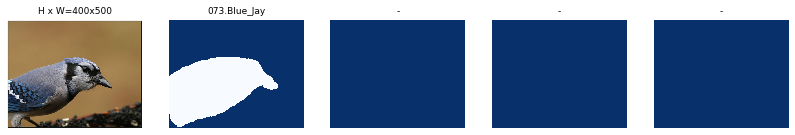

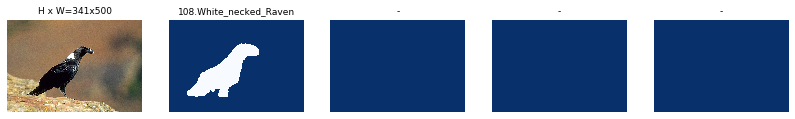

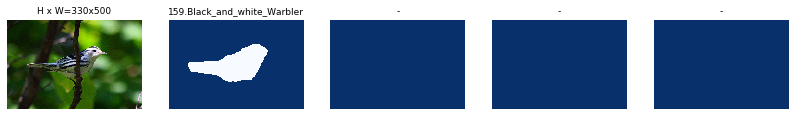

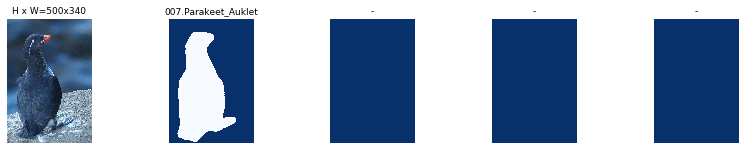

In [7]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  2012 D:/DataSet/birds/jpg\image_05853.jpg
image                    shape: (400, 500, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (400, 500, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:  194.00000  max:  194.00000  int32
bbox                     shape: (1, 4)                min:  107.00000  max:  411.00000  int32


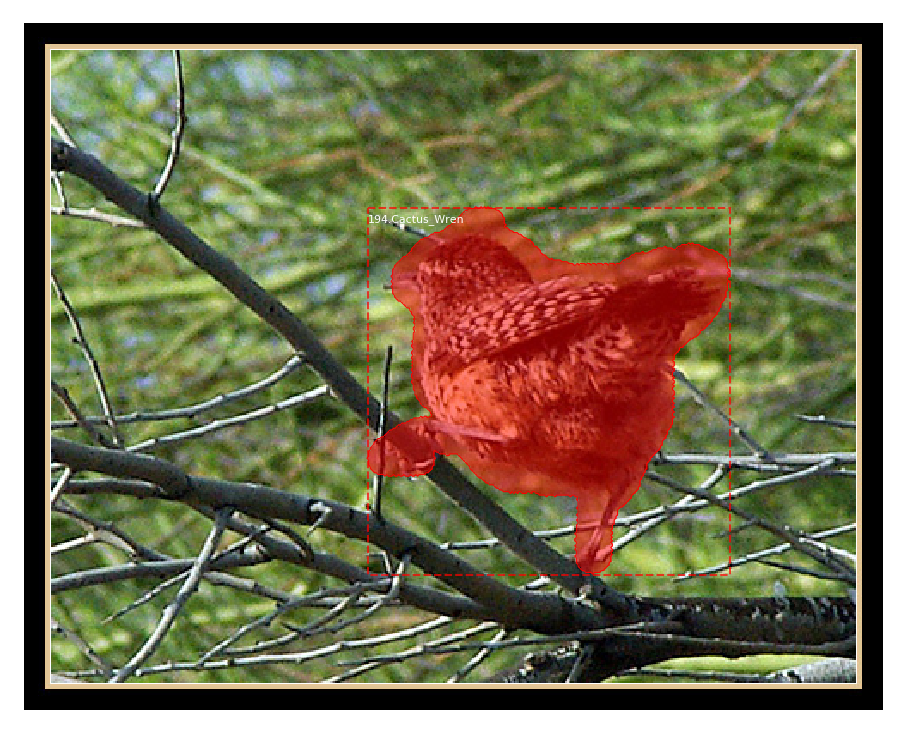

In [9]:
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id:  426 D:/DataSet/birds/jpg\image_01316.jpg
Original shape:  (316, 500, 3)
image                    shape: (960, 960, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (960, 960, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:   45.00000  max:   45.00000  int32
bbox                     shape: (1, 4)                min:   30.00000  max:  745.00000  int32


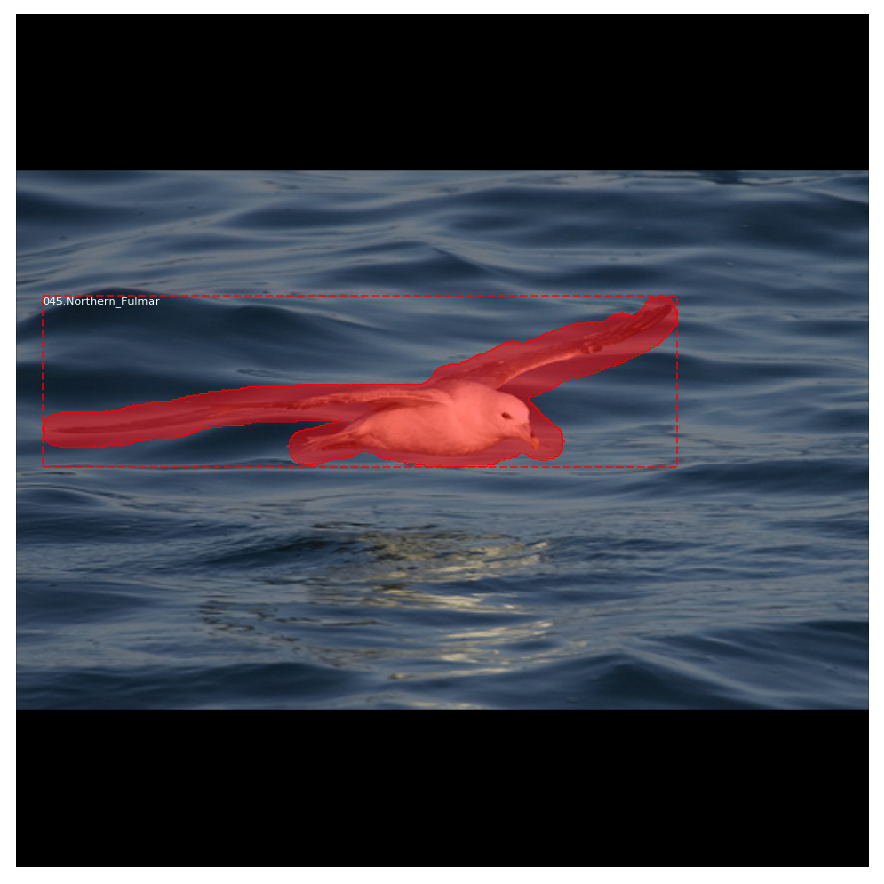

In [10]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (960, 960, 3)         min:    0.00000  max:  254.00000  uint8
image_meta               shape: (213,)                min:    0.00000  max: 4809.00000  float64
class_ids                shape: (1,)                  min:   50.00000  max:   50.00000  int32
bbox                     shape: (1, 4)                min:   46.00000  max:  709.00000  int32
mask                     shape: (960, 960, 1)         min:    0.00000  max:    1.00000  bool


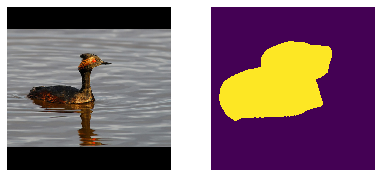

In [5]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = load_image_gt(dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

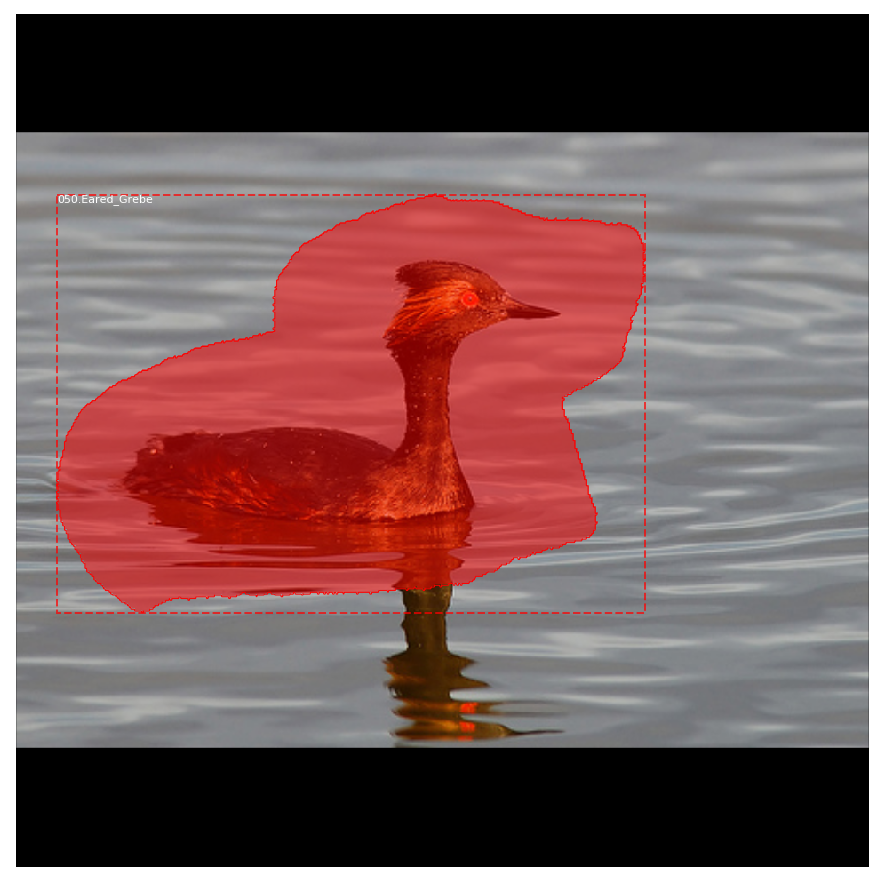

In [6]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000  bool


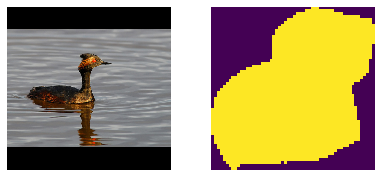

In [7]:
image, image_meta, class_ids, bbox, mask = load_image_gt(dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])